# Import Libraries

In [ ]:
# Import Required Libraries
import os # Saving of files
import sys # Calling of functions in of other files saved on  google drive
import sqlite3  # Database management and SQL queries
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computing and array operations
from google.colab import drive  # Google Drive access for loading files in Colab

# Mount Google Drive in order to access and store data
drive.mount('/content/drive')
module_path = '/content/drive/MyDrive/Blink Detection/Code'

# Import the blink detection functions
if module_path not in sys.path:
    sys.path.append(module_path)

from blink_detection_functions import (identify_troughs_and_stable_points, analyze_troughs, identify_blinks, third_pass, validate_blinks, calculate_performance_from_dict, track_fatigue, bandpass_filter, scale_signal, reduce_noise, remove_outliers, plot_eeg_signal_with_dict, analyze_blink_similarity, plot_confusion_matrix)

Mounted at /content/drive


# Holds Settings

In [ ]:
# Preloaded Settings
settings = 2  # 1: Loads the Blink Dataset. 2: Loads our small sample of collected and labeled data 3: Load the blink dataset with different settings

# ~~~Common Settings~~~
DisplayOutput = True # If False this will turn off every graph and dictionary as the test runs, If True it will only display graphs based on low_threshold (THIS MUST BE TRUE and low_threshold must be 1 IF YOU WANT TO SAVE GRAPHS AS JPGS, But it doesn't matter for the CSV outputs)
low_threshold = 1 # If you don't want to display everything you can tune this to only display tests the fall under this value, so set to 1 if you want to see everything and 0 to display nothing. I used it around 0.3 to see what type of data the program was struggling with
FileLabeled = True # Lets you check if the file you're working on is labeled or not (As setup now unlabledled files just have blink set to 0 at every point) This is just changes how graphs are generated and won't display perfomance metrics

# If you want to do faster testing you can load a single test instead of the whole dataset
one_test = False
specific_test = "2025_03_05_Data1(N5S)"

# If you want to save all the data output to a specific folder (Be careful if you're connected to google drive this generates a lot of small files and google drive can be, particualar about that)
SaveOutput  = False
output_folder = '/content/drive/MyDrive/Blink Detection/Output/'
output_folder_name = 'OurData' # This folder will be created in the output folder location if it doesn't exist already. If you wanted to this could be moved under settings in order to make sure different data is saved in different sub folders

# Rough Fatigue Esimation Tracking
fatigue_time_window = 60   # The time in seconds you want to average data over, so if set to 60 it will look at the average over a minute
fatigue_time_increment = 30   # How often you want to take a snapshot of the data in seconds, at 30 seconds it means there will be 30 secounds of overlap with the previous 60 second test
fatigue_increment = 0.1  # If blinks and getting more frequent and lasting longer a 'fatigue score' will go up by 0.1 this is abitrary as of now and needs improvemnet
trough_search_radius = 10   # The radius around a trough in seconds that the program will use to search for the highest peak
proximity_threshold=  0.2  # How close in seconds an estimated blink needs to be to a labeled blink to get flaged as true positive

# ~~~Unique Settings~~~
if settings == 1:
    db_path = '/content/drive/MyDrive/Blink Detection/Datasets/BLINKData_Labeled.db' # The location of the Database you are attempting to work on
    RemoveOutliers = True # If you want to remove outliers in individual waveforms

    # Digital Filtering Settings
    lowcut = 0.3 # In HZ the lowcut used by the bandpass filter
    highcut = 28 # In Hz the highcut used by the bandpass filter
    sample_rate = 250 # The sampling date of the data you're using
    noise_threshold = 0.35444163267506573 # The systems removes any troughs smaller than the noise treshold to help make sure only blinks get through

    # Outliers
    outlier_threshold = 10 # Determines how far from the upper and lowerbound values that a point must be at to count as an outlier
    outlier_lowerbound = 56.3283293856677 # The percent that acts as the lower quartile for the signal
    outlier_upperbound = 87.05909901941988 # The percent that acts as the upper quartile for the signal

    # 2nd‑pass blink detection
    dup_trough_proximity_threshold = 0.3 # This settings makes sure that no troughs are being doubled counted in the data as anything within that time in seconds will be labeled only once
    symmetry_threshold = 51.1662910568745 # The lowest symetry allowed for a blink
    blink_trough_threshold = 0.1 # The minimum depth a trough can be to get scored as a blink
    max_blink_duration = 0.45 # The General Maximum Blink duration allowed in seconds
    min_blink_duration = 0.1 # The General Minimum Blink duration allowed in seconds

    # Blink‑likelihood weights
    min_duration_percent = 1.0 # Weight of score given if a blink is longer then minimum duration
    max_duration_percent = 64.37231191603038 # Weight of score given if a blink is shorter then maximum duration
    symmetry_percent = 99.0 # Weight of score given if a blink is within symmetry
    amplitude_percent = 7.69513579269388 # Weight of score given if a blink is within amplitude

    # 3rd‑pass tuning
    tp_amplitude_threshold = 2.0 # The width around the blink amplitude that is used to calculate the 3rd pass data
    tp_symmetry_threshold = 70.07846734816201 # The width around the symettry that is used to calculate the 3rd pass data
    likely_blink_percent = 100.0 # If a blink is over this liklihood is it considered high confidence and gets weighed more when calculating personal metrics
    unlikey_blink_percent = 0.0 # If a blink is under this liklihood is it considered low  confidence and gets weighed less when calculating personal metrics
    likey_blink_factor = 1.0 # If a blink is likely you can weight the new metrics to be closer to likly blinks
    unlikey_blink_factor = 0.1 # If a blink is unlikely you can weight the new metrics to be closer to likly blinks
elif settings == 2:
    db_path = '/content/drive/MyDrive/Blink Detection/Datasets/OurData_Labeled.db'
    #db_path = '/content/drive/MyDrive/Blink Detection/Datasets/OurData_Unlabeled.db'
    RemoveOutliers = False

    # EEG filter
    lowcut = 0.5
    highcut = 18
    sample_rate = 100
    noise_threshold = 0.3

    # 2nd‑pass blink detection
    dup_trough_proximity_threshold = 0.3
    symmetry_threshold = 50
    blink_trough_threshold = 1.2
    max_blink_duration = 0.4
    min_blink_duration = 0.1

    # Blink‑likelihood weights
    min_duration_percent = 15
    max_duration_percent = 20
    symmetry_percent = 30
    amplitude_percent = 35

    # 3rd‑pass tuning
    tp_amplitude_threshold = 0.7
    tp_symmetry_threshold = 50
    likely_blink_percent = 70
    unlikey_blink_percent = 50
    likey_blink_factor = 1.5
    unlikey_blink_factor = 0.8

elif settings == 3:
    db_path = '/content/drive/MyDrive/Blink Detection/Datasets/BLINKData_Labeled.db'
    RemoveOutliers = True

    # EEG filter
    lowcut = 0.3
    highcut = 28
    sample_rate = 250
    noise_threshold = 0.24780766197882384

    # Outliers
    outlier_threshold = 6.806941045351024
    outlier_lowerbound = 52.742059603901474
    outlier_upperbound = 94.08643903381625

    # 2nd‑pass blink detection
    dup_trough_proximity_threshold = 0.3
    symmetry_threshold = 100
    blink_trough_threshold = 0.1
    max_blink_duration  = 0.6362059325504344
    min_blink_duration  = 0.05050194547406508

    # Blink‑likelihood weights
    min_duration_percent = 69.63618547443994
    max_duration_percent = 66.86306117307444
    symmetry_percent = 61.28315466801316
    amplitude_percent = 82.812042499988

    # 3rd‑pass tuning
    tp_amplitude_threshold = 0.781905687859286
    tp_symmetry_threshold = 53.83150440671442
    likely_blink_percent = 95.16804988497066
    unlikey_blink_percent = 35.199958809104984
    likey_blink_factor = 1.8553765534746027
    unlikey_blink_factor = 0.2222485934135988

else:
    raise ValueError(f"Unknown settings: {settings!r}")

# Connect to the database containing the blink data
conn = sqlite3.connect(db_path)

# Collect all the table names from the database (tables are individual tests)
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)['name'].tolist()

# Initialize a confusion matrix for total system evaluation
global_confusion = np.array([[0, 0], [0, 0]])


# Print all the table names so it's easy to select just 1 if you want to load it
print(tables)

['2025_02_19_Data1(NRS)', '2025_03_05_Data1(N5S)', '2025_03_19_Data1(NRS)']


# Main Processing Loop


Processing table: 2025_02_19_Data1(NRS) (Dataset: 2025_02_19_Data1(NRS))
Table: 2025_02_19_Data1(NRS), Dataset: 2025_02_19_Data1(NRS)


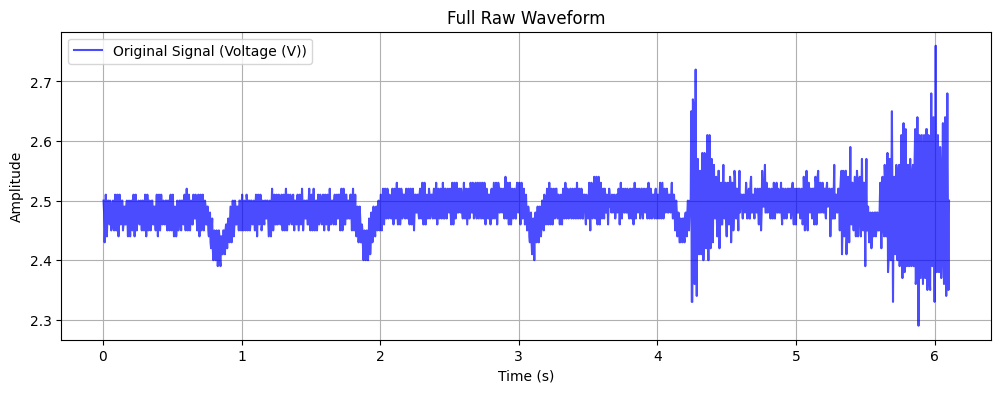

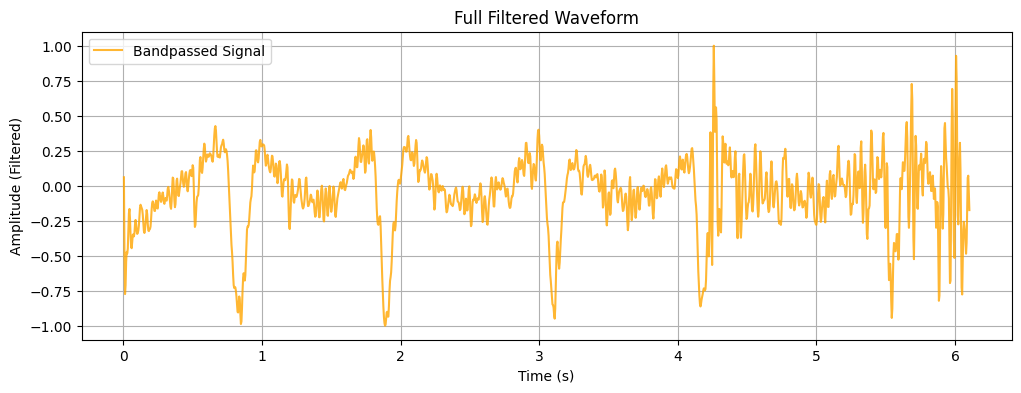

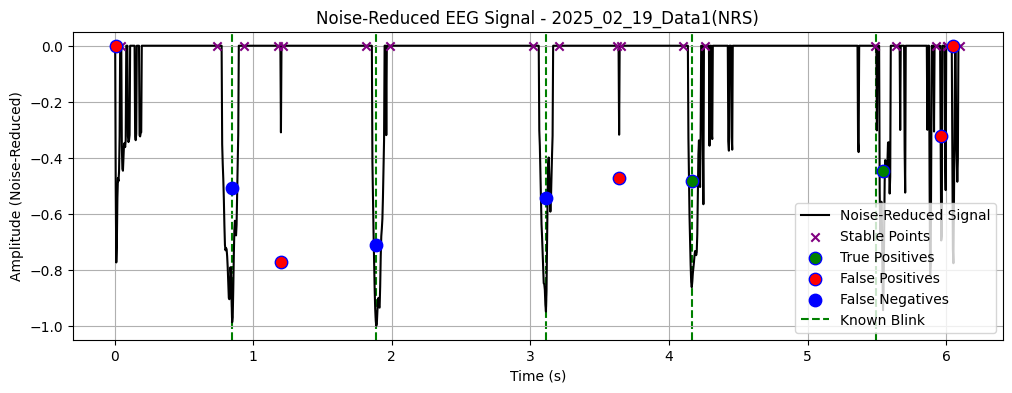


Compare Blink Critera:
       Feature  Mean  Std Dev   Min    Max  Range
     Amplitude  1.03     0.38  0.32   1.50   1.18
Duration_total  0.11     0.06  0.03   0.20   0.16
      Symmetry 76.53    21.88 25.00 100.00  75.00


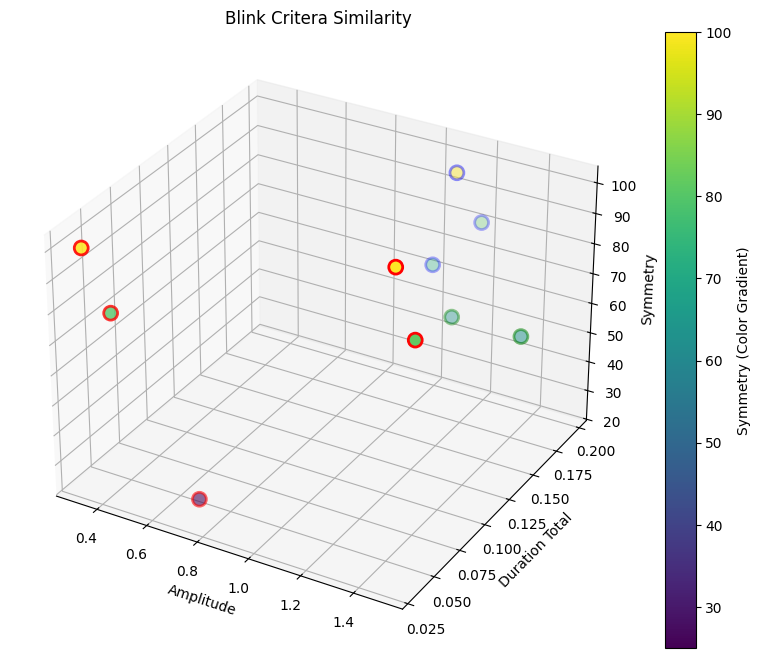

   trough_time stable_points    amplitude  duration_opening  duration_closing  \
0  0.012        (0.004, 0.044)  0.721149   0.008             0.032              
1  0.848         (0.74, 0.936)  1.190040   0.108             0.088              
2  1.200         (1.18, 1.216)  0.407879   0.020             0.016              
3  1.888        (1.816, 1.988)  1.092625   0.072             0.100              
4  3.112         (3.02, 3.204)  1.134182   0.092             0.092              
5  3.640        (3.624, 3.656)  0.320661   0.016             0.016              
6  4.164         (4.104, 4.26)  1.496852   0.060             0.096              
7  5.544         (5.484, 5.64)  1.230860   0.060             0.096              
8  5.964        (5.928, 6.008)  1.383165   0.036             0.044              
9  6.052        (6.008, 6.096)  1.276402   0.044             0.044              

   symmetry    blink_likelyhood  is_blink  duration_total  opening_velocity  \
0   25.000000  50.0          

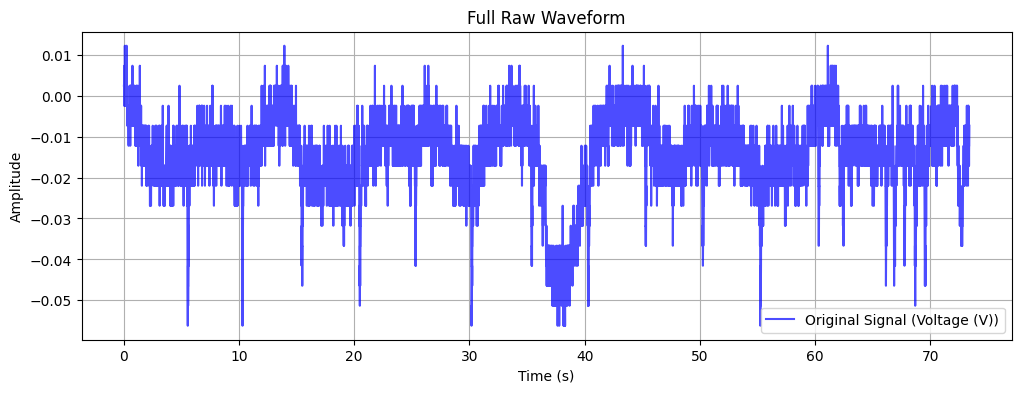

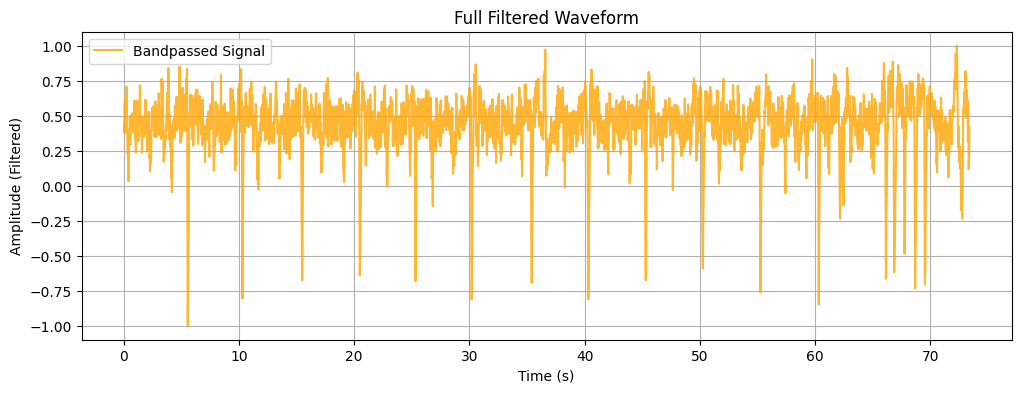

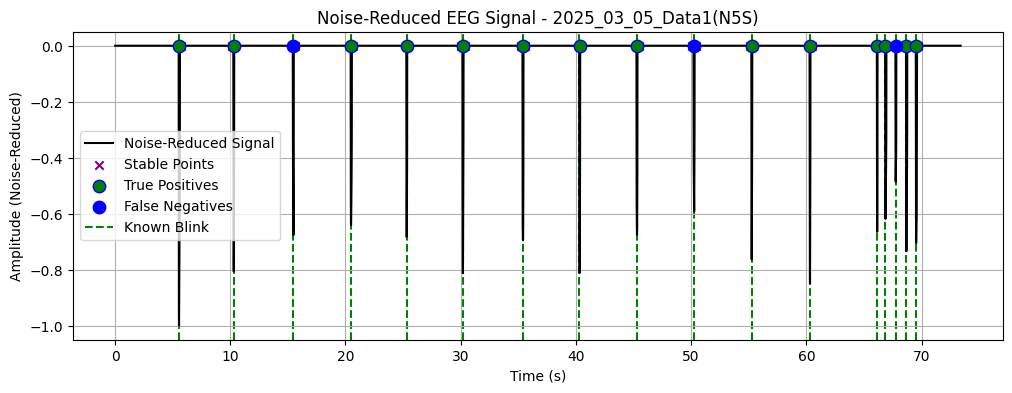


Compare Blink Critera:
Feature         Mean  Std Dev  Min   Max   Range
     Amplitude  1.31  0.14     1.05  1.68  0.63 
Duration_total  0.26  0.03     0.22  0.31  0.09 
      Symmetry 72.22 15.58    41.18 99.98 58.80 


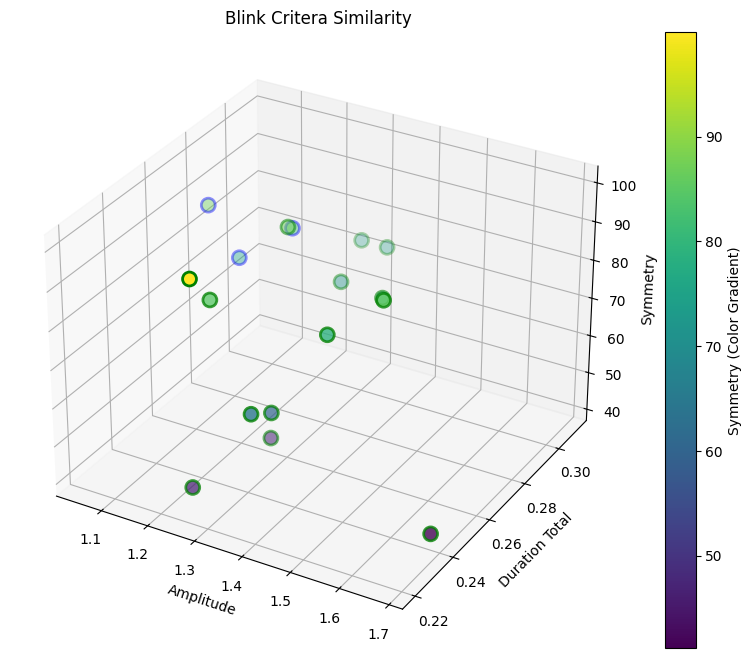

    trough_time stable_points            amplitude  duration_opening  \
0    5.551464      (5.481448, 5.721496)  1.680765   0.070016           
1   10.302613    (10.182577, 10.442645)  1.502630   0.120036           
2   15.483984    (15.323932, 15.614016)  1.189337   0.160052           
3   20.475231    (20.395219, 20.645275)  1.307308   0.080012           
4   25.306415     (25.236391, 25.45646)  1.269248   0.070024           
5   30.187583     (30.067571, 30.34762)  1.422779   0.120012           
6   35.408859     (35.258815, 35.53889)  1.221281   0.150044           
7   40.320075    (40.230037, 40.470119)  1.351172   0.090038           
8   45.301403    (45.211368, 45.441436)  1.351274   0.090035           
9   50.262519    (50.102481, 50.382556)  1.114428   0.160038           
10  55.253791    (55.143756, 55.363803)  1.272931   0.110035           
11  60.315040    (60.205017, 60.455062)  1.427306   0.110023           
12  66.146438    (66.036415, 66.276466)  1.224941   0.110023    

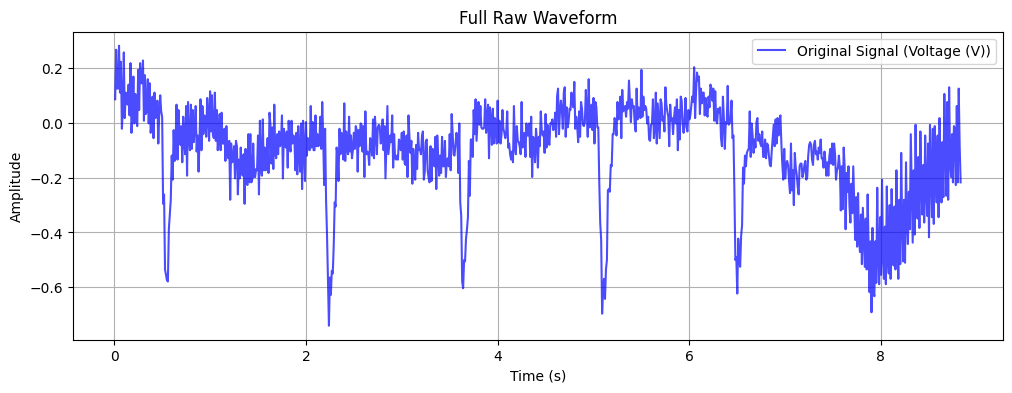

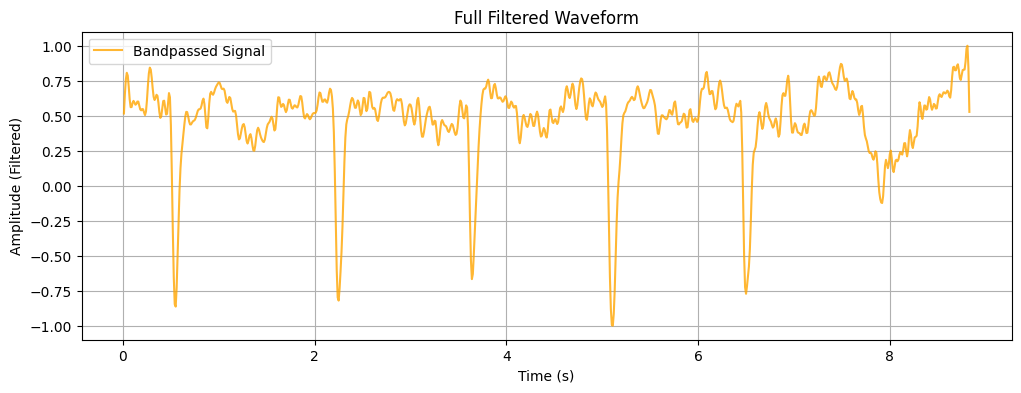

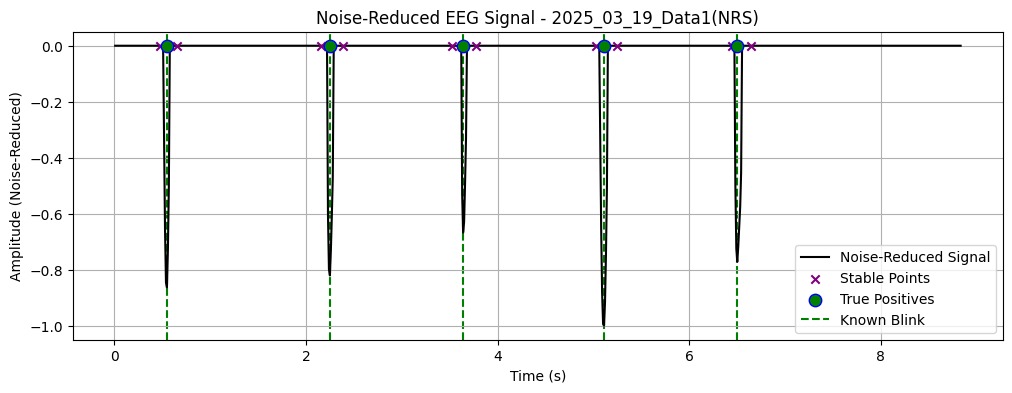


Compare Blink Critera:
Feature         Mean  Std Dev  Min   Max   Range
     Amplitude  1.44  0.10     1.32  1.60  0.28 
Duration_total  0.22  0.02     0.18  0.25  0.07 
      Symmetry 64.05 16.10    42.86 92.31 49.45 


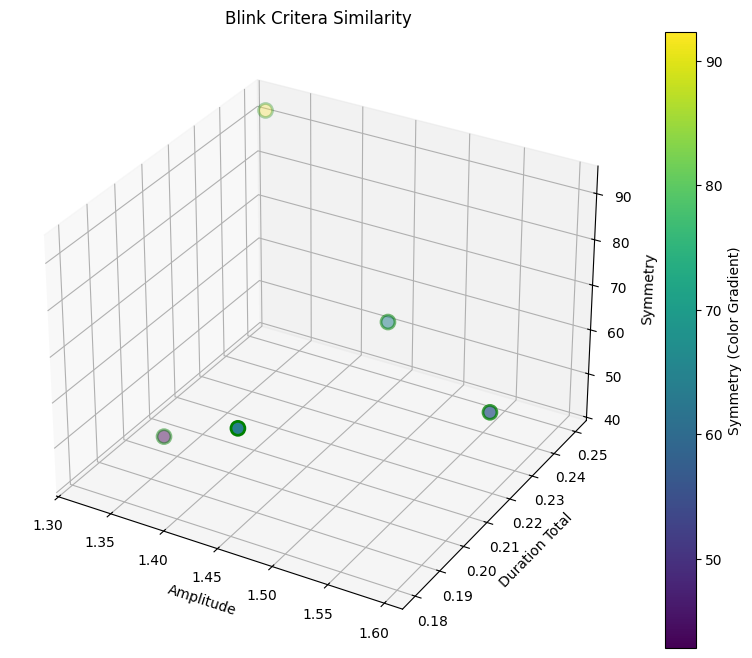

   trough_time stable_points          amplitude  duration_opening  \
0  0.550136      (0.48012, 0.660156)  1.458097   0.070016           
1  2.250584       (2.160556, 2.3906)  1.480589   0.090028           
2  3.640912     (3.520884, 3.770944)  1.318186   0.120028           
3  5.111320     (5.031296, 5.251368)  1.595666   0.080024           
4  6.501664     (6.441656, 6.641688)  1.337617   0.060008           

   duration_closing  symmetry   blink_likelyhood  is_blink  duration_total  \
0  0.110020          63.639338   70.0             1         0.180036         
1  0.140016          64.298366   70.0             1         0.230044         
2  0.130032          92.306509   70.0             1         0.250060         
3  0.140048          57.140409   70.0             1         0.220072         
4  0.140024          42.855510  100.0             1         0.200032         

   opening_velocity  closing_velocity blink_validation  
0  20.825201         13.253020         TP               
1 

In [ ]:
for table in tables: # Loops through all the tests in the dataset
    if one_test and table != specific_test: #If you're doing one test and the names don't match just skip the test
        continue

    # Pull data from the test, where data is the waveform, time_array is the times, blink_times are the times blink happen, total_samples is the number of samples in the test and the dataset_label is the tests name
    data = pd.read_sql(f"SELECT * FROM [{table}]", conn)
    time_array = data['Time (s)'].values
    blink_times = data[data['Blink'] == 1]['Time (s)']
    total_samples = len(data)
    dataset_label = data['Dataset'].iloc[0]
    print(f"Processing table: {table} (Dataset: {dataset_label})")

    # Initialize the Potential Blinks Dictionary that is used to store the data of potential blinks
    PB_Dictionary = { "trough_time": [], "stable_points": [], "amplitude": [], "duration_opening": [], "duration_closing": [], "symmetry": [], "blink_likelyhood": [], "is_blink": [], "duration_total": [], "opening_velocity": [], "closing_velocity": [], "blink_validation": [], }

    # Runs the function that digitally filter the waveform, if wanted remove outliers, scale the signal and then create the simplified waveform (I called it reduce noise early on and haven't bothered changing it)
    filtered_signal = bandpass_filter(data['Voltage (V)'], lowcut, highcut, sample_rate)
    if RemoveOutliers:
      filtered_signal = remove_outliers(filtered_signal, outlier_threshold, outlier_lowerbound, outlier_upperbound) # This function can causes weird spikes in the data sometimes, it doesn't seem to cause detection issues but I would look into it to make it work consistently
    filtered_signal = scale_signal(filtered_signal)
    scaled_signal = reduce_noise(filtered_signal, noise_threshold)

    # Fills the dictionary with the troughs, their stable points along with each troughs ampltiude (Phase 1)
    PB_Dictionary["trough_time"], PB_Dictionary["stable_points"], PB_Dictionary["amplitude"] = identify_troughs_and_stable_points(scaled_signal, 0.2, time_array, filtered_signal,search_radius=trough_search_radius, trough_proximity_threshold=dup_trough_proximity_threshold)

    # Calculates the duration, symmetry and velcoity of each blink
    PB_Dictionary["duration_total"], PB_Dictionary["duration_opening"], PB_Dictionary["duration_closing"], PB_Dictionary["symmetry"], PB_Dictionary["opening_velocity"], PB_Dictionary["closing_velocity"] = analyze_troughs(scaled_signal, PB_Dictionary)

    # Calculates an original blink likelyhood and defines the starting blinks (Phase 2)
    PB_Dictionary["blink_likelyhood"], PB_Dictionary["is_blink"] = identify_blinks(PB_Dictionary, min_blink_duration, max_blink_duration, blink_trough_threshold, symmetry_threshold, min_duration_percent, max_duration_percent, symmetry_percent, amplitude_percent)

    # Runs a third pass using the calculated blink metrics (Phase 3)
    PB_Dictionary = third_pass(PB_Dictionary, tp_amplitude_threshold, tp_symmetry_threshold, "iqr", likely_blink_percent, unlikey_blink_percent, likey_blink_factor, unlikey_blink_factor)

    # Convert the PB_Dictionary to Python lists to fix errors I was getting with the append function
    for key, value in PB_Dictionary.items():
        if isinstance(value, np.ndarray):
            PB_Dictionary[key] = value.tolist()

    # If the file is labeled we Validate blinks against the real blink data.
    if FileLabeled:
        PB_Dictionary = validate_blinks(PB_Dictionary, blink_times, proximity_threshold)
    # If the file isn't labled just clear the blink_validation row (Since unlabled files just have 0 for all blink times this just makes sure no accidental labeling happens)
    else:
        n = len(PB_Dictionary.get("is_blink", []))
        PB_Dictionary["blink_validation"] = [None] * n

    # Calculate a quick estimation to see if blinks are getting more frequent and lasting longers
    fatigue_score = track_fatigue(PB_Dictionary, fatigue_time_window, fatigue_time_increment, fatigue_increment)

    # Makes sure all the lists are equal length in the dictionary to avoid data being misaligned
    max_length = max(len(v) for v in PB_Dictionary.values())
    for key in PB_Dictionary:
        while len(PB_Dictionary[key]) < max_length:
            PB_Dictionary[key].append(None)

    # Conversts the database into a Pandas Dataframe to make exporting and viewing easier
    dftwo = pd.DataFrame(PB_Dictionary)

    # If the file is labeled calculate the statics of the test and add them to the global confusion matrix
    if FileLabeled:
      precision, recall, accuracy, global_confusion = calculate_performance_from_dict(PB_Dictionary, total_samples, global_confusion)

    # If you want to display the output this just shows all the data based on your low_threshold value
    if(DisplayOutput):
      if precision <= low_threshold or recall <= low_threshold or accuracy <= low_threshold:
          print(f"Table: {table}, Dataset: {dataset_label}")
          plot_signal(data, 'Time (s)', scaled_signal, filtered_signal, PB_Dictionary, blink_times, channel="Voltage (V)", table=table, title=f'Noise-Reduced EEG Signal - {dataset_label}', output_folder=output_folder, SaveOutput = SaveOutput, FileLabeled = FileLabeled)
          analyze_blink_similarity(PB_Dictionary)
          pd.set_option('display.max_rows', None)
          pd.set_option('display.max_columns', None)
          pd.set_option('display.width', None)
          pd.set_option('display.colheader_justify', 'left')
          print(dftwo)
          if FileLabeled:
            print(f"\nPerformance Metrics for {dataset_label} - {table}:")
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.2f}")
            print(f"Accuracy: {accuracy:.2f}")

    # if SaveOutput is True save the CSV files to the correct output folder
    if SaveOutput:
        folder_csv = os.path.join(output_folder, output_folder_name, f"{table}")
        if not os.path.exists(folder_csv):
            os.makedirs(folder_csv)
        data[['Time (s)', 'Voltage (V)']].to_csv(os.path.join(folder_csv, f"{table}_raw_data.csv"), index=False)
        pd.DataFrame({"Time (s)": data["Time (s)"], "Voltage (V)": filtered_signal}).to_csv(os.path.join(folder_csv, f"{table}_filtered_data.csv"), index=False)
        pd.DataFrame({"Time (s)": data["Time (s)"], "Voltage (V)": scaled_signal}).to_csv(os.path.join(folder_csv, f"{table}_simplified_data.csv"), index=False)
        pd.DataFrame(PB_Dictionary).to_csv(os.path.join(folder_csv, f"{table}_PB_Dictionary.csv"), index=False)


Final Confusion Matrix (Cumulative):


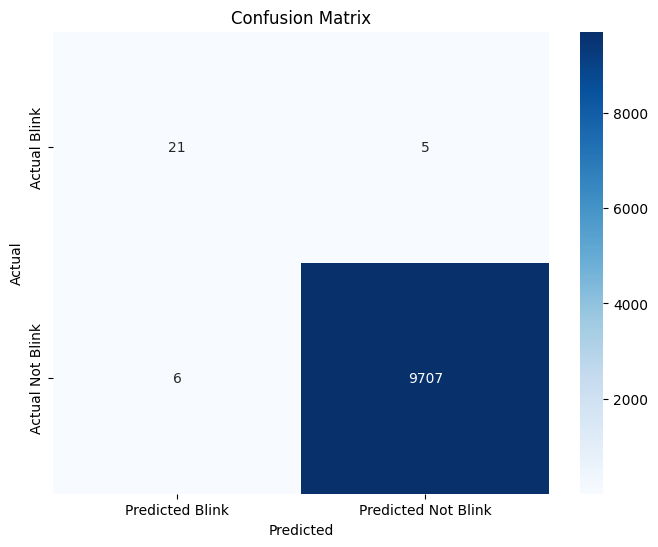


Final Performance Metrics (Cumulative):
Precision: 0.81
Recall: 0.78
Accuracy: 1.00


In [ ]:
# Display the final cumulative confusion matrix.
if FileLabeled:
  print("\nFinal Confusion Matrix (Cumulative):")
  plot_confusion_matrix(global_confusion)

conn.close()